In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import hydrant.topology.geom as gm
import hydrant.topology.aggregate as agg
import subprocess
import os
from   shapely.geometry import Point

In [2]:
# inputs
path_out = './output/'
pfafs = ['71','78'] # 71 Saskatchewan, 78 Colombia
riv_path = '/project/def-kshook/uofc-share/MERIT-Basins/MERIT_Hydro_v07_Basins_v01_bugfix1/pfaf_level_02/'
cat_path = '/project/def-kshook/uofc-share/MERIT-Basins/MERIT_Hydro_v07_Basins_v01_bugfix1/pfaf_level_02/'
cst_path = '/project/def-kshook/uofc-share/MERIT-Basins/MERIT_Hydro_v07_Basins_v01_bugfix1/coastal_hillslopes/'
riv_file_template = 'riv_pfaf_*_MERIT_Hydro_v07_Basins_v01_bugfix1.shp'
cat_file_template = 'cat_pfaf_*_MERIT_Hydro_v07_Basins_v01_bugfix1.shp'
cst_file_template = 'hillslope_*_clean.shp'

In [3]:
if not os.path.isdir(path_out):
    os.makedirs(path_out)

# Load and append the pfaf

In [4]:
riv, cat = gm.merit_read_file (pfafs,
                               riv_path,
                               riv_file_template,
                               cat_path,
                               cat_file_template,
                               path_cst = cst_path,
                               cst_file_template = cst_file_template)

# prepare the network topology

In [5]:
riv, cat = gm.prepare_ntopo(riv=riv,\
                            riv_cols={'id':'COMID', 'next_id':'NextDownID'},\
                            cat=cat,\
                            cat_cols={'id':'COMID', 'hillslope':'hillslope', 'area' :'unitarea'},\
                            network = 'merit')

# Example-1 From basins of identified pfafs that intersect with target stations in Alberta

In [6]:
# set the case name
prefix = 'stations_merit_'

In [7]:
data = {
    'Station ID': ['05BE004', '05BH004', '05BL004', '05CC002'],
    'seg ID': [71028039, 71027942, 71034975, 71022153],
    'Station name': [
        'BOW RIVER NEAR SEEBE',
        'BOW RIVER AT CALGARY',
        'HIGHWOOD RIVER BELOW LITTLE BOW CANAL',
        'RED DEER RIVER AT RED DEER'
    ],
    'up': [0, 0, 0, 0],
    'X': [-115.03,-114.05,-113.86,-113.82],
    'Y': [51.11,    51.05,  50.58,  52.27]
}

# Create a DataFrame from the dictionary
stations_seg_id = pd.DataFrame(data)

# Create a points from the dictionary
geometry = [Point(xy) for xy in zip(data['X'], data['Y'])]
stations_points = gpd.GeoDataFrame(data, geometry=geometry, crs='EPSG:4326')

In [8]:
# slice the domain for various stations and their seg ID
cat_slice, riv_slice = gm.subset_ntopo(cat=cat,\
                                       cat_cols={'id':'COMID'},\
                                       riv=riv,\
                                       riv_cols={'id':'COMID', 'next_id':'NextDownID'},\
                                       outlet_id=list(stations_seg_id['seg ID']))



<AxesSubplot:>

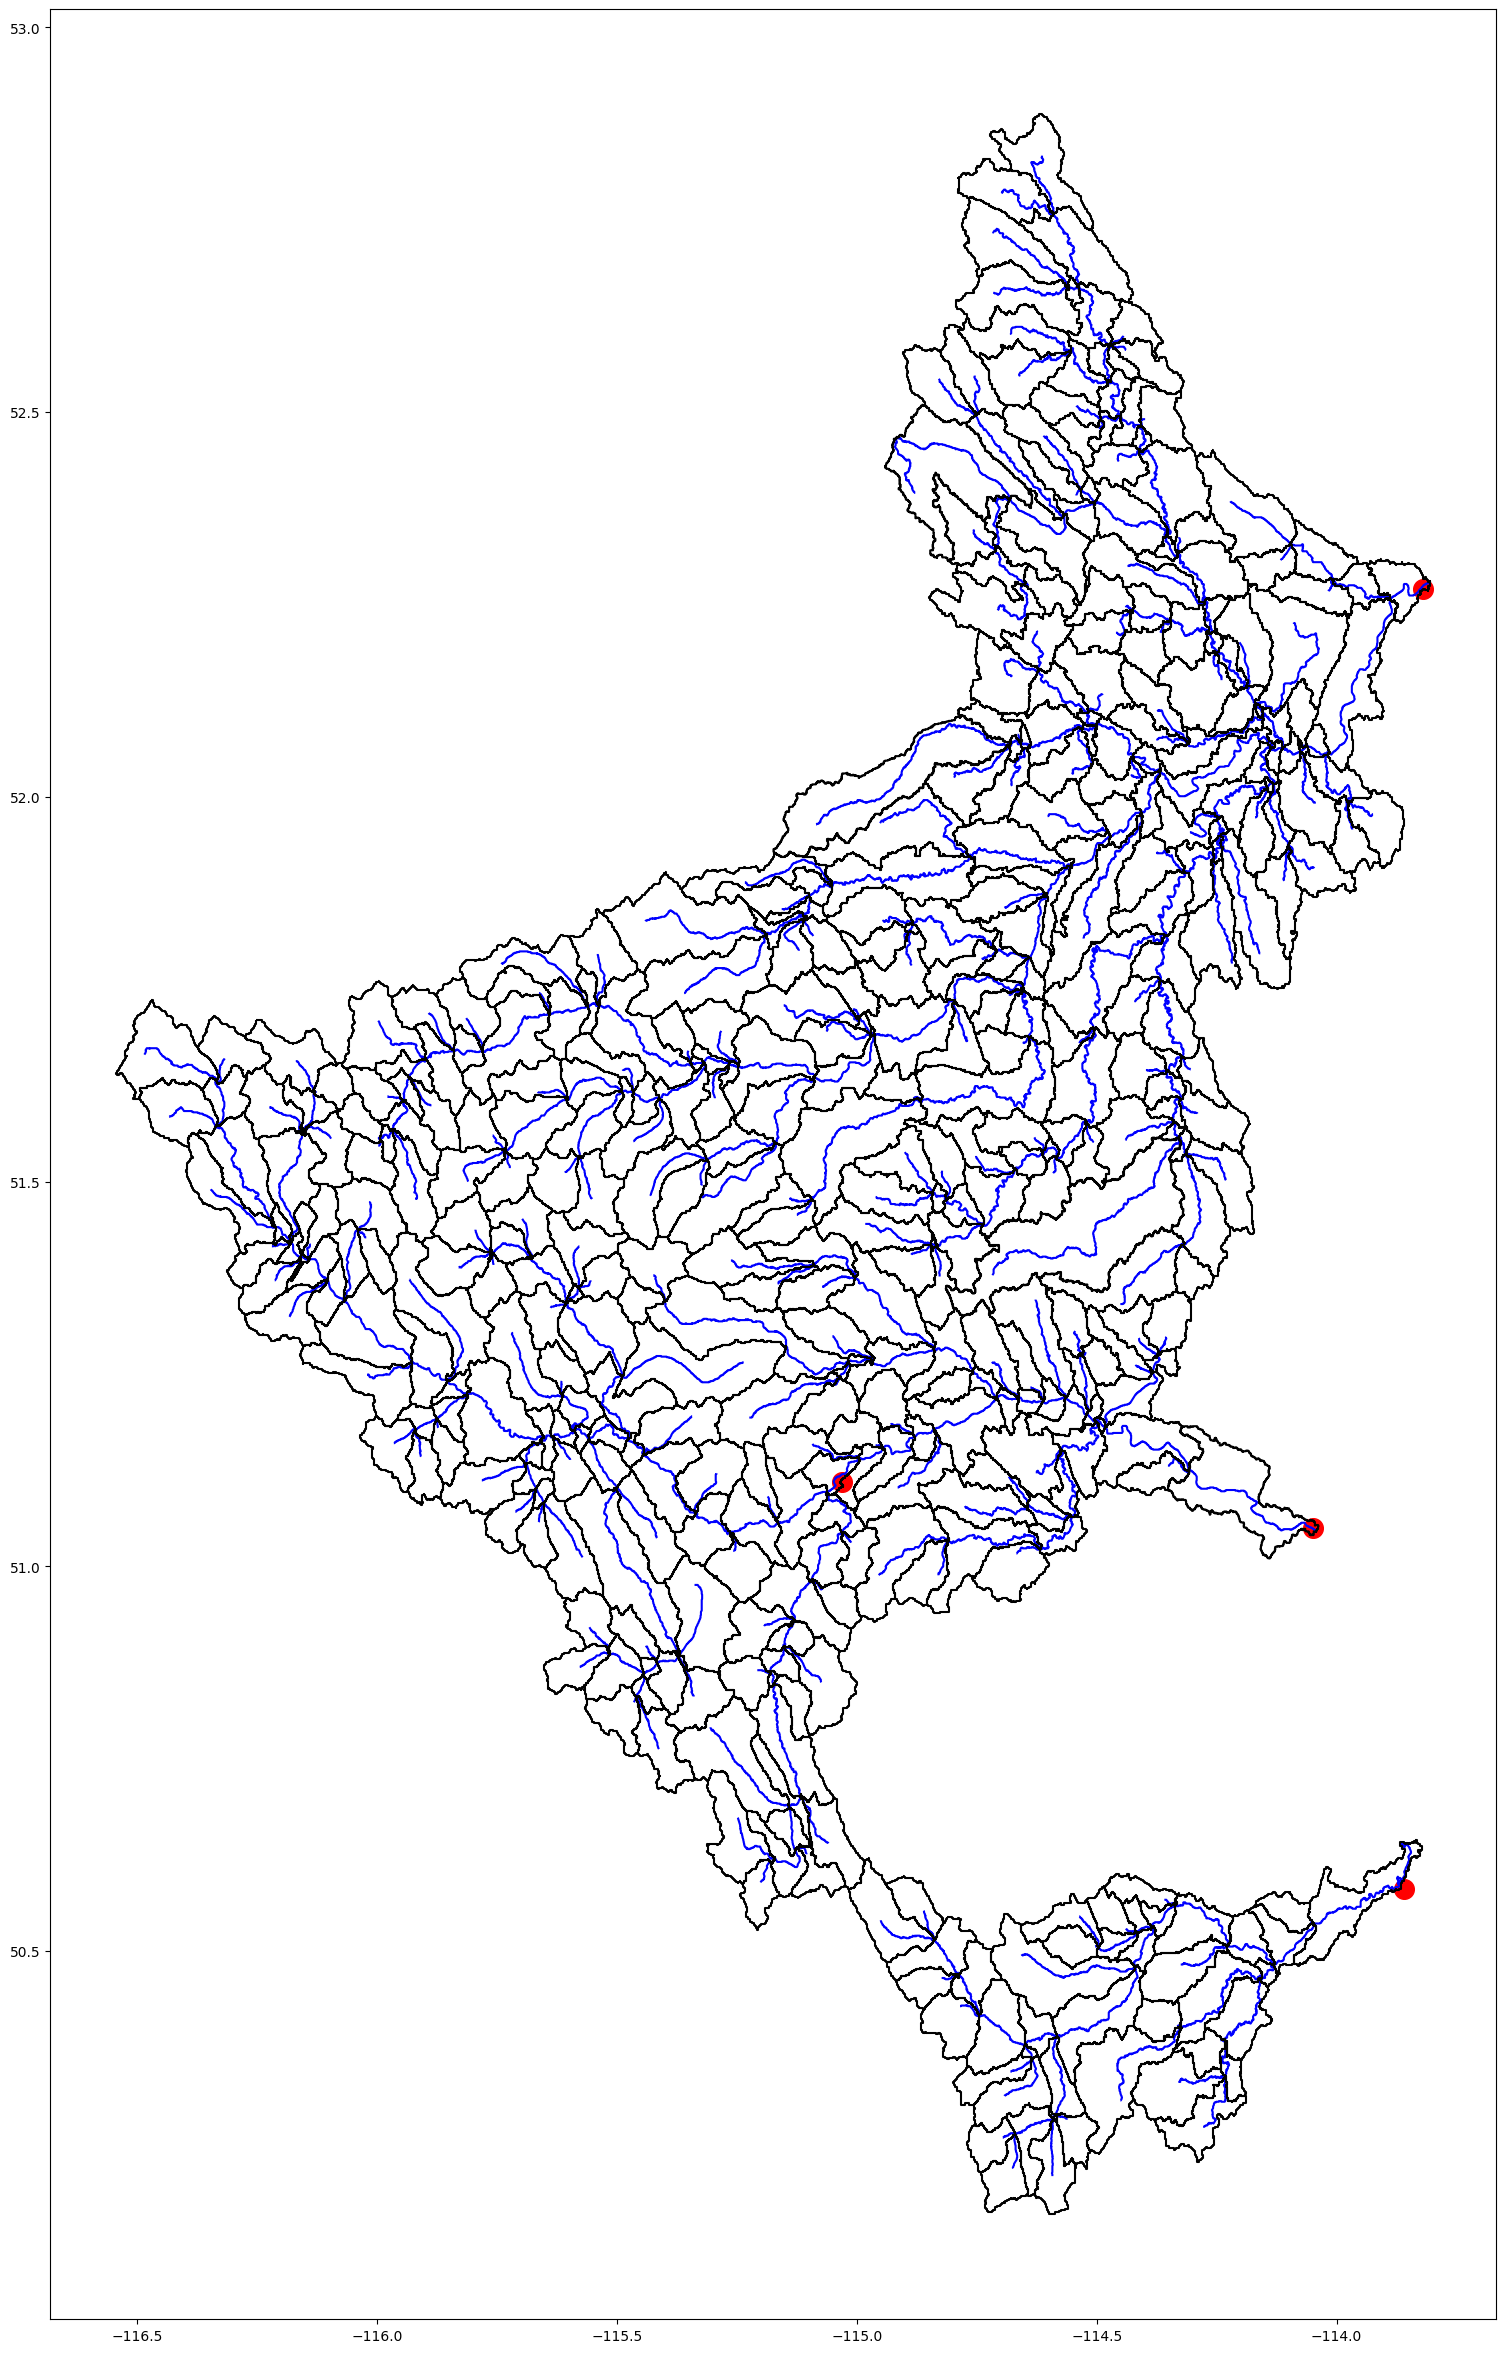

In [9]:
fig, ax = plt.subplots(figsize=(20,30))
riv_slice.plot(ax=ax, color='b')
cat_slice.boundary.plot(ax=ax, color='k')
stations_points.plot(ax=ax, color='r', markersize=200)


In [10]:
# caclulate pfaf for riv_slice
riv_slice = agg.pfaf(riv_slice, df_info = {'id':'COMID', 'next':'NextDownID', 'uparea': 'uparea', 'area': 'unitarea'})

# pass pfaf to cat_slice
cat_slice['pfaf'] = riv_slice['pfaf']
cat_slice['pfaf_region'] = riv_slice['pfaf_region']

[10 20 30]


<AxesSubplot:>

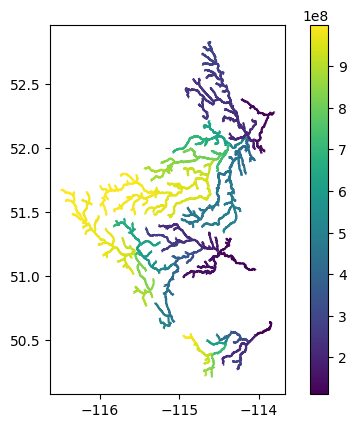

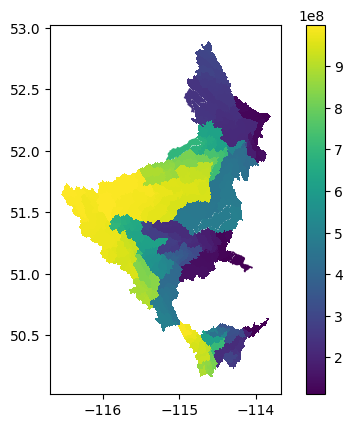

In [11]:
# # Create a new figure and axes
fig, ax = plt.subplots()

# Plot the first river GeoDataFrame
riv_slice.plot(column='pfaf', cmap='viridis', legend=True, ax=ax)

# # Create a new figure and axes
fig, ax = plt.subplots()

# Plot the first river GeoDataFrame
cat_slice.plot(column='pfaf', cmap='viridis', legend=True, ax=ax)

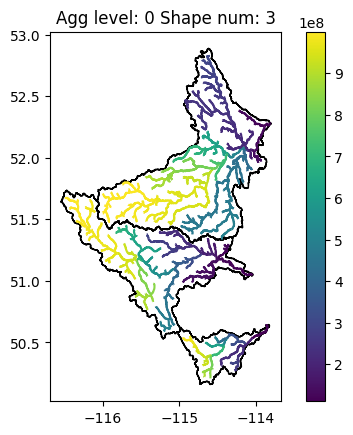

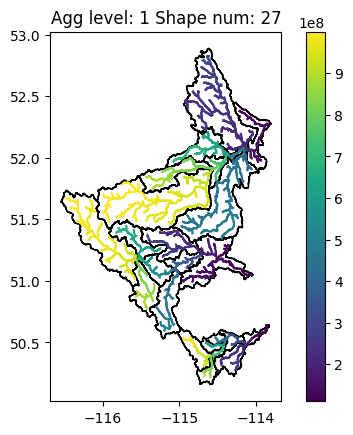

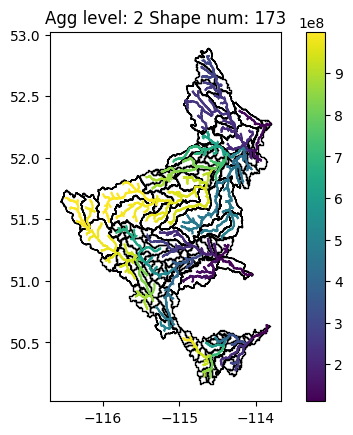

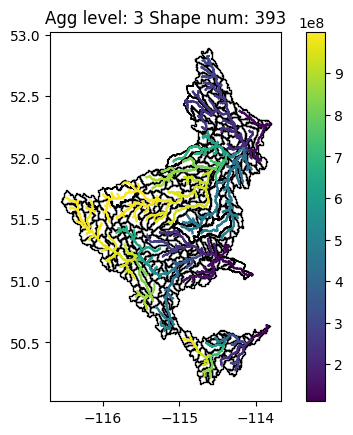

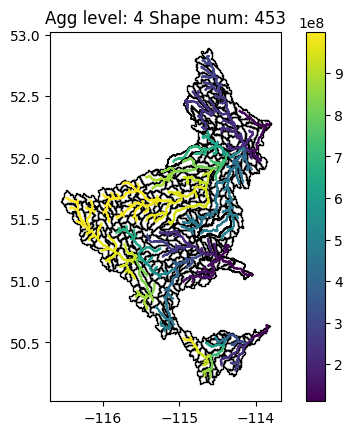

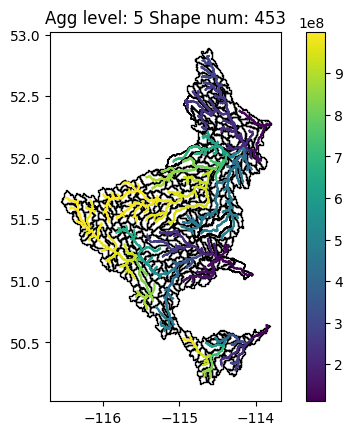

In [15]:
for i in np.arange(6):
    
    
    cat_slice_agg = agg.pfaf_agg (cat_slice, df_info={'pfaf': 'pfaf', 'pfaf_region': 'pfaf_region'}, depth_agg = i)
    
    # # Create a new figure and axes
    fig, ax = plt.subplots()
    riv_slice.plot(column='pfaf', cmap='viridis', legend=True, ax=ax)
    cat_slice_agg.plot(facecolor='none', ax=ax)

    # print the aggregated shapes
    plt.title('Agg level: '+str(i)+ ' Shape num: '+ str(len(cat_slice_agg)))